Authors: Marius-Constantin Dinu, Jose A. Arjona-Medina

Date: 01-04-2020

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**.

---


# Deep Reinforcement Lerning Lectures - Policy Gradients (REINFORCE)

### Install and import packages

In [ ]:
!apt update
!apt install -y xvfb x11-utils python-opengl ffmpeg
!pip install gym pyvirtualdisplay
!pip install box2d-py
!pip install gym[Box_2D]

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

# Auxiliary Python imports
import io
import glob
import base64
import random
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

# Environment import and set logger level to display error only
import gym; gym.logger.set_level(40)
from gym.wrappers import Monitor

# Plotting and notebook imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import HTML, display, clear_output

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()

In [ ]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Auxiliary Methods

In [ ]:
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


def create_env(env_id='LunarLander-v2'):
    # initialize environment
    env = wrap_env(gym.make(env_id))
    action_size = env.action_space.n
    state_size = env.observation_space.shape[0]
    return env, action_size, state_size


def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


def transforms(state):
    state_t = torch.FloatTensor(state).to(device)
    return state_t


def test_environment(env, agent=None):
    state = env.reset()

    for i in range(200):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = action.numpy()
        state, reward, done, info = env.step(action)
        if done:
            env.reset()

    env.close()


def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner, reward_scale=1.0):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')

    plt.subplot(322)

    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')

    plt.subplot(323)

    # plot return
    all_returns = np.array(runner.buffer.all_returns)/reward_scale
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)/reward_scale # rescale back to original return
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')

    plt.subplot(324)

    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    # plot variance
    variance_arr = np.array(runner.logger.compute_gradient_variance())
    plt.plot(range(0, len(variance_arr)), variance_arr)
    plt.xlabel('Episode')
    plt.ylabel('Variance')

    plt.show()


"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gym` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as LunarLander-v2.
To access the Box2D packages, make sure you have installed gym via `pip install gym` and the Box2D simulator via `pip install box2d box2d-kengz` command in the terminal in advance.

In [ ]:
env, _, _ = create_env()
test_environment(env)
show_video()

### Define Policy Network

In [ ]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        h = torch.relu(self.norm(self.dense_layer_1(x)))
        h = torch.relu(self.norm(self.dense_layer_2(h)))
        h = self.output(h)
        return torch.softmax(h, dim=-1) #-1 to take softmax of last dimension

class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(PolicyNet, self).__init__()
        self.actor = ActorNet(state_size, action_size, hidden_size)

    def forward(self, x):
        raise NotImplementedError

    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(probs=action_probs)
        action = dist.sample().squeeze()
        log_probs = dist.log_prob(action)
        return action, log_probs

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(probs=action_probs)
        log_probs = dist.log_prob(action)
        entropy = dist.entropy()
        return log_probs, entropy

### Training Buffer

In [ ]:
class Transition(object):
    def __init__(self, state, action, reward, log_probs):
        self.state = state
        self.action = action
        self.reward = reward
        self.g_return = 0.0
        self.log_probs = log_probs


class Episode(object):
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1

    def states(self):
        return [s.state for s in self.transitions]

    def actions(self):
        return [a.action for a in self.transitions]

    def rewards(self):
        return [r.reward for r in self.transitions]

    def returns(self):
        return [r.g_return for r in self.transitions]

    def calculate_return(self):
        # turn rewards into return
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + self.discount*g_return
            return_array[i] = g_return
            self.transitions[i].g_return = g_return
        return return_array


class ReplayBuffer(object):
    def __init__(self, min_transitions):
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []

    def _empty(self):
        del self.buffer[:]

    def add(self, episode):
        """Saves a transition."""
        episode.calculate_return()
        self.buffer = episode.transitions

    def update_stats(self):
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        self._empty()

    def __len__(self):
        return len(self.buffer)


def grad_variance(g):
    return np.mean(g**2) - np.mean(g)**2


class Logger(object):
    def __init__(self):
        self.gradients = []

    def add_gradients(self, grad):
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

### Define Agent

In [ ]:
class Agent(object):
    def __init__(self, buffer, state_size, action_size, hidden_size, learning_rate, transforms, logger):
        self.action_size = action_size
        self.buffer = buffer
        self.policy = PolicyNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.transforms = transforms
        self.logger = logger

    def act(self, state):
        with torch.no_grad():
            state_t = self.transforms(state).view(1, -1)
            action, log_probs = self.policy.act(state_t)
        return action.cpu(), log_probs

    def train(self):
        # sample batch from buffer
        samples = self.buffer.buffer
        episode_returns = []
        states = []
        actions = []
        old_log_probs = []
        for s in samples:
            states += [self.transforms(s.state),]
            episode_returns += [s.g_return,]
            actions += [s.action,]
            old_log_probs += [s.log_probs,]

        # create tensors
        state_t = torch.stack(states, dim=0).to(device)
        action_t = torch.LongTensor(actions).to(device)
        return_t = torch.FloatTensor(episode_returns).to(device)
        old_log_probs_t = torch.stack(old_log_probs, dim=0).to(device)

        # perform training step
        log_probs, entropy = self.policy.evaluate(state_t, action_t)
        loss = -torch.mean(log_probs*return_t)

        self.optimizer.zero_grad()
        loss.backward()
        self.logger.add_gradients(np.concatenate([param.grad.view(-1).detach().cpu().numpy() for param in self.policy.parameters()], axis=0))
        self.optimizer.step()

        return loss.detach().cpu().numpy(), entropy.mean().detach().cpu().numpy()

### Define Task Runner

In [ ]:
class Runner(object):
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=5000, reward_scale=0.01,
                 use_buffer_reset=True, stats_interval=10, print_stats=True, min_average_reward=190, render=False):
        self.env = env
        self.agent = agent
        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        # store stats for plotting
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        # stats for running episodes
        self.timesteps = 0

    def run(self):
        with tqdm(range(self.n_episodes)) as pbar:
            for e in pbar:
                state = self.env.reset()
                stats_loss = 0.
                # stopping condition for training if agent reaches the amount of reward
                if False:#len(self.stats_rewards_list) > self.stats_interval and np.mean(self.stats_rewards_list[-self.stats_interval:],axis=0)[1] > self.min_average_reward:
                    print("Stopping at episode {} with average rewards of {} in last {} episodes".
                        format(e, np.mean(self.stats_rewards_list[-self.stats_interval:],axis=0)[1], self.stats_interval))
                    break

                # create new episode
                episode = Episode(discount=self.discount)

                done = False
                # train in each episode until episode is done
                while not done:
                    self.timesteps += 1
                    if self.render: self.env.render()

                    # select an action from the agent's policy
                    action, log_probs = self.agent.act(state)

                    # enter action into the env
                    next_state, reward, done, _ = self.env.step(action.numpy())
                    episode.total_reward += reward

                    # store agent trajectory
                    transition = Transition(state=state, action=action, reward=(reward*self.reward_scale), log_probs=log_probs)
                    episode.append(transition)

                    # update stats and update agent if done
                    if done:
                        # add current episode to the replay buffer
                        self.buffer.add(episode)
                        self.stats_rewards_list.append((e, episode.total_reward, episode.size()))

                        # skip if stored episodes are less than the batch size
                        if len(self.buffer) < self.buffer.min_transitions: break

                        # update the network
                        loss, entropy = self.agent.train()
                        stats_loss += loss
                        self.stats_entropy_list.append(entropy)
                        self.buffer.update_stats()
                        if self.use_buffer_reset: self.buffer.reset()
                        if self.print_stats and e % self.stats_interval == 0:
                            pbar.set_description("[%03d] Reward: %.4f" % (e, np.mean(self.stats_rewards_list[-self.stats_interval:],axis=0)[1]))

                    state = next_state

### Train Agent

In [ ]:
# create environment
env, action_size, state_size = create_env()

seed = 31
# set seed
set_seed(env, seed=seed)

# hyperparameters
episodes = 3000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
learning_rate = 0.0003 # learning rate for optimizer
discount = 0.99 # discount factor gamma value
reward_scale = 1. # reward scaling

min_transitions = 1 # number of minimum transitions until update is triggered
use_buffer_reset = True # resets the buffer after every update

# additional settings
print_stats = True
render = False

In [ ]:
logger = Logger()
buffer = ReplayBuffer(min_transitions=min_transitions)
agent = Agent(buffer=buffer, state_size=state_size, action_size=action_size, hidden_size=hidden_size,
              learning_rate=learning_rate, transforms=transforms, logger=logger)
runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger, discount=discount, n_episodes=episodes, reward_scale=reward_scale,
                use_buffer_reset=use_buffer_reset, print_stats=print_stats, render=render)

In [ ]:
runner.run()

  0%|          | 0/3000 [00:00<?, ?it/s]

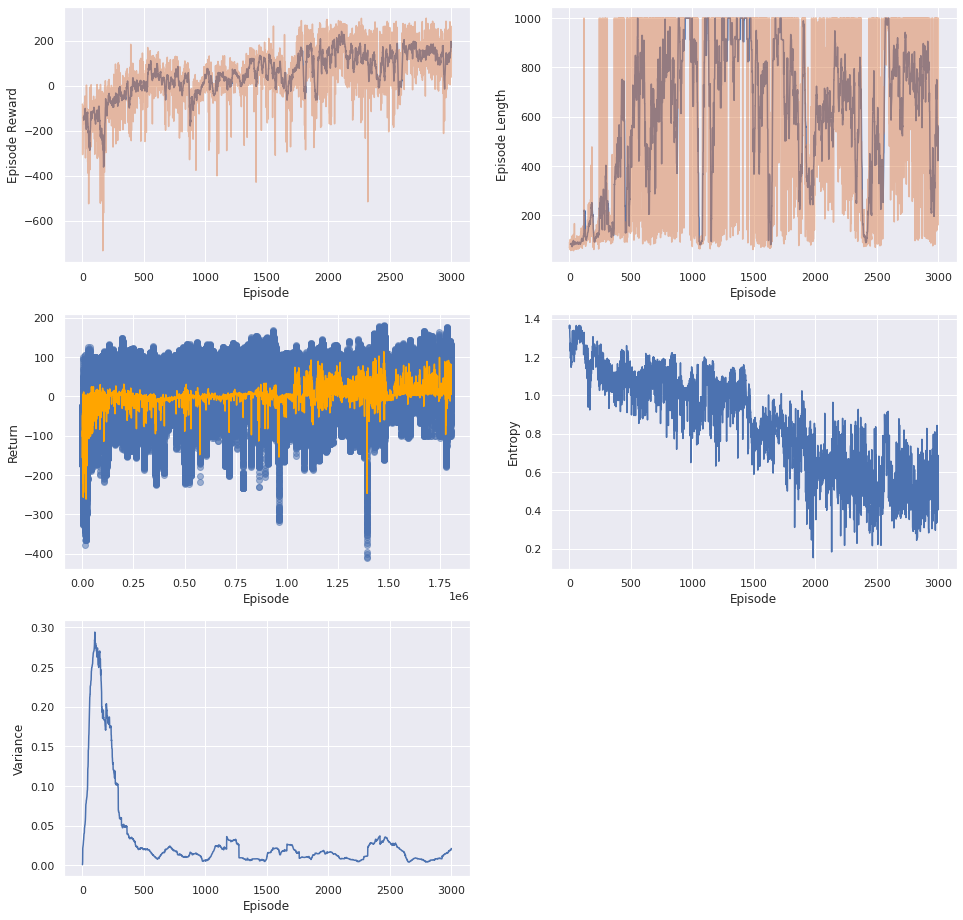

In [ ]:
plot_results(runner, reward_scale=reward_scale)

In [ ]:
env, _, _ = create_env()
test_environment(env=env, agent=agent)
show_video()